# Configuration

In [1]:
%%configure -f 
{"numExecutors":6, "executorMemory": "4G", "executorCores":6}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1578693885177_0001,pyspark,idle,Link,Link,


In [2]:
# Configure Global variables

def configure_process():
    """Initial process configuration that sets global variables used throughout the notebook.

    Parameters: None

    Returns: None
   """

    global bucket_name, init_k, last_k, step, max_iter, tol, \
        verbose, score_method, anomaly_threshold, \
        train_file, full_file, test_file, sample_size
    
    # Configure here
    bucket_name = "s3://abd-juma-bucket/"
    init_k = 60
    last_k = 330
    step = 30
    max_iter = 50
    tol = 1.0e-5
    verbose = False
    score_method = "silhouette_score" 
    anomaly_threshold = 200
    train_file = "kddcup.data_10_percent"
    full_file = "kddcup.data"
    test_file = "kddcup_sample_1.data"
    sample_size = 30000

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1578693885177_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Apenas válido se usar o Zeppelin ou a Spark Shell
# Se correr via Jupyter (Usa a Spark Gateway Livy, correr o parágrafo inicial)
# Configurar recursos suficiente para o Spark (PS: Depende do tamanho do cluster e das máquinas utilizadas)

import re
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

def configure_spark(verbose):
    """Configure Spark Resources When running via Zeppelin or with Spark-shell

    Parameters:
    verbose (bool): Switch to turn on or off verbose logging

    Returns: None
   """

    if re.match(r"livy+", spark.sparkContext._conf.get('spark.app.name')): 
        print("Running behind Livy... Bypassing SparkContext configuration.")
    else:
        conf = spark.sparkContext._conf.setAll(
        [('spark.executor.memory', '4G'), 
         ('spark.app.name', 'KDD99 Kmeans'), 
         ('spark.cores.max', '14'), 
         ('spark.driver.memory','4G'), 
         ('spark.executor.instances', '7')])

        if verbose:
            print(spark.sparkContext._conf.getAll())
    

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Functions and Procedures

In [4]:
import os
import subprocess

def run_cmd(cmd, verbose):
    """Auxiliar method to run system commands, toggling stderr and stdout in case of verbose setting be True or False

    Parameters:
    cmd (string): Command to execute in the system
    verbose (bool): Switch to turn on or off verbose logging

    Returns:
    output (string): stdout and optionally stderr if verbose is True
   """

    if verbose:
        output = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True)
        print(output)
        return output
    else:
        return subprocess.check_output(cmd, shell=True)

def transfer_raw_data(bucket_name, sample_size, verbose):
    """Method that fetches the raw datasets from KDD Repository and uploads to S3

    Parameters:
    bucket_name (string): S3 URI of bucket to upload the raw dataset objects to
    sample_size (int): Number of unobserved samples to extract for test phase
    verbose (bool): Switch to turn on or off verbose logging

    Returns: None
   """

    #Get Raw datasets
    run_cmd("wget --directory-prefix=/tmp -nv http://kdd.ics.uci.edu/databases/kddcup99/" + train_file + ".gz", verbose)
    run_cmd("wget --directory-prefix=/tmp -nv http://kdd.ics.uci.edu/databases/kddcup99/" + full_file + ".gz", verbose)
    run_cmd("gunzip /tmp/" + train_file + ".gz", verbose)
    run_cmd("aws s3 cp /tmp/" + train_file + " " + bucket_name, verbose)
    run_cmd("gunzip /tmp/" + full_file + ".gz", verbose)
    run_cmd("aws s3 cp /tmp/" + full_file + " " + bucket_name, verbose)

    #Generate sample
    row_count = int(run_cmd("wc -l /tmp/" + full_file, False).split()[0])

    if sample_size > row_count:
        print("Please provide a lower sample size. Max value: " + str(row_count))
    else:
        run_cmd("shuf -n " + str(sample_size) + " /tmp/" + full_file + " > /tmp/" + test_file, verbose)
        run_cmd("aws s3 cp /tmp/" + test_file + " " + bucket_name, verbose)
        
    #Cleanup
    run_cmd("rm /tmp/kdd*", verbose)

    if verbose:
        print("Listing raw data objects in S3:")
        run_cmd("aws s3 ls " + bucket_name, True)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col

def load_rawdata(bucket_name, train_file, test_file, verbose):
    
    """Read KDD raw data from S3/HDFS and return structured Spark DataFrames

    Parameters:
    bucket_name (string): Bucket address to get the S3 (Objects)/HDFS (Files) from
    train_file (string): Name of train file
    test_file (string): Name of test file
    verbose (bool): Switch to turn on or off verbose logging

    Returns:
    data_df_train (DataFrame): Spark DataFrame with training data
    data_df_sample (DataFrame): Spark DataFrame with test data

   """
    
    # Unfortunately Livy version in EMR is ignoring numExecutors configuration. 
    # If SparkContext doesn't report on number of executors, we'll assume 5
    if sc._conf.get('spark.executor.instances'):
        nbr_of_partitions = int(sc._conf.get('spark.executor.instances'))
    else:
        nbr_of_partitions = 5
   
    # Carregar a raw data para um RDD
    raw_data_train = get_wrangled_rdd(bucket_name + train_file, nbr_of_partitions) 
    raw_data_sample = get_wrangled_rdd(bucket_name + test_file, nbr_of_partitions) 

    # Transformar em DataFrame com os Data Types corretos (a auto inferência de tipos no PySpark não parece funcionar bem)
    data_df_train = get_structured_df(raw_data_train)
    data_df_sample = get_structured_df(raw_data_sample)
    
    # Verbose switch
    if verbose:
        print("Describing and printing schema of Train DataFrame:")
        data_df_train.describe().show()
        data_df_train.printSchema()

    return data_df_train, data_df_sample

def get_wrangled_rdd(file_name, nbr_part):
    
    """Get raw file/object and return wrangled RDD

    Parameters:
    file_name (string): Full address of file to work on
    nbr_part (int): Number of RDD partitions

    Returns:
    (RDD): Wrangled RDD ready to work on

   """

    return sc.textFile(file_name, nbr_part). \
        map(lambda x: x.encode("ascii", "ignore")). \
        map(lambda line: line.split(','))
    
def get_structured_df(kdd_rdd):
    
    """Get Wrangled RDD and return Structured DataFrame

    Parameters:
    kdd_rdd (RDD): RDD Object to generate DataFrame

    Returns:
    (DataFrame): Structured DataFrame with correct Data Types and Column Names

   """
   
    return (kdd_rdd.toDF([
        "duration", "protocol_type", "service", "flag",
        "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent",
        "hot", "num_failed_logins", "logged_in", "num_compromised",
        "root_shell", "su_attempted", "num_root", "num_file_creations",
        "num_shells", "num_access_files", "num_outbound_cmds",
        "is_host_login", "is_guest_login", "count", "srv_count",
        "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
        "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
        "dst_host_count", "dst_host_srv_count",
        "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate", "dst_host_srv_serror_rate",
        "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
        "label"]).select(col('duration').cast(DoubleType()),
                        col('protocol_type').cast(StringType()),
                        col('service').cast(StringType()),
                        col('flag').cast(StringType()),
                        col('src_bytes').cast(DoubleType()),
                        col('dst_bytes').cast(DoubleType()),
                        col('land').cast(DoubleType()),
                        col('wrong_fragment').cast(DoubleType()),
                        col('urgent').cast(DoubleType()),
                        col('hot').cast(DoubleType()),
                        col('num_failed_logins').cast(DoubleType()),
                        col('logged_in').cast(DoubleType()),
                        col('num_compromised').cast(DoubleType()),
                        col('root_shell').cast(DoubleType()),
                        col('su_attempted').cast(DoubleType()),
                        col('num_root').cast(DoubleType()),
                        col('num_file_creations').cast(DoubleType()),
                        col('num_shells').cast(DoubleType()),
                        col('num_access_files').cast(DoubleType()),
                        col('num_outbound_cmds').cast(DoubleType()),
                        col('is_host_login').cast(DoubleType()),
                        col('is_guest_login').cast(DoubleType()),
                        col('count').cast(DoubleType()),
                        col('srv_count').cast(DoubleType()),
                        col('serror_rate').cast(DoubleType()),
                        col('srv_serror_rate').cast(DoubleType()),
                        col('rerror_rate').cast(DoubleType()),
                        col('srv_rerror_rate').cast(DoubleType()),
                        col('same_srv_rate').cast(DoubleType()),
                        col('diff_srv_rate').cast(DoubleType()),
                        col('srv_diff_host_rate').cast(DoubleType()),
                        col('dst_host_count').cast(DoubleType()),
                        col('dst_host_srv_count').cast(DoubleType()),
                        col('dst_host_same_srv_rate').cast(DoubleType()),
                        col('dst_host_diff_srv_rate').cast(DoubleType()),
                        col('dst_host_same_src_port_rate').cast(DoubleType()),
                        col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                        col('dst_host_serror_rate').cast(DoubleType()),
                        col('dst_host_srv_serror_rate').cast(DoubleType()),
                        col('dst_host_rerror_rate').cast(DoubleType()),
                        col('dst_host_srv_rerror_rate').cast(DoubleType()),
                        col('label').cast(StringType())))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
import numpy as np
from pyspark.ml.feature import StringIndexer, OneHotEncoder, OneHotEncoderEstimator, StandardScaler, VectorAssembler
from pyspark.ml.linalg import Vectors, Vector
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline, PipelineModel
from pyspark.mllib.clustering import KMeansModel

def fitPipeline(data, k, max_iter, tol, verbose):
    
    """Define and fit a Pipeline for a KMeansModel

    Comments: Code partially inspired in KMeans Spark Scala implementation from Sandy Ryza’s “AdvancedAnalytics with Spark: Patterns for Learning From Data at Scale” book, Uri Laserson, Sean Owen & Josh Wills, published by O’Reilly in 2017, second edition

    Parameters:
    data (DataFrame): Data to extract feature vectors and to fit the KMeansModel
    k (int): Number of clusters for KMeansModel
    max_iter (int): Parameter for maximum number of cluster reassignement iterations
    tol (float): Parameter for the convergence tolerance for iterative algorithms
    verbose (bool): Switch to turn on or off verbose logging

    Returns:
    pipeline (Pipeline): Object with pipeline definition
    pipelineModel (PipelineModel): Object with fitted pipeline

   """

    # Listta de features numericas
    numericCols = ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
    
    # Lista de features categoricas
    categoricalCols = ['protocol_type', 'service', 'flag']
    
    # Gerar indices para as features categoricas
    indexers = [ StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col))
                 for col in categoricalCols ]

    # Gerar vetor binario com os indices das features categoricas
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_vec".format(indexer.getOutputCol()))
                 for indexer in indexers ]
    
    # Gerar um unico vetor com todas as features
    assembler = VectorAssembler(
        inputCols=numericCols + [encoder.getOutputCol() for encoder in encoders], 
        outputCol="featureVector")
    
    # Proceder a normalizacao das features
    scaler = StandardScaler(
        inputCol="featureVector", 
        outputCol="scaledFeatureVector", 
        withStd=True, 
        withMean=False)
    
    # Fazer fit ao KMeans model com as features standardizadas
    kmeans = KMeans(). \
        setSeed(int(np.random.randint(100, size=1))). \
        setTol(tol). \
        setPredictionCol("cluster"). \
        setFeaturesCol("scaledFeatureVector"). \
        setK(k). \
        setMaxIter(max_iter)
    
    # Juntar os stages todos numa pipeline
    pipeline = Pipeline(
        stages=indexers + encoders + [assembler, scaler, kmeans])

    # Executar todos os stages
    pipelineModel = pipeline.fit(data)
    
    if verbose:
        print("Pipeline Summary: " + str(pipeline.getStages()))

    return pipeline, pipelineModel

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
from pyspark.sql import Window
from pyspark.sql.functions import sum, log2, log
from pyspark.ml.evaluation import ClusteringEvaluator
from sys import maxsize

def search_hyperparameters(data_df, init_k, last_k, step, max_iter, tol, verbose):
    
    """Auxiliar hyper-parameter (k) search method that returns per each k the Within Set Sum of Squared Errors, Weighted Cluster Entropy and Cluster Silhouette Score

    Comments: Weighted Cluster Entropy Code inspired in KMeans Spark Scala implementation from Sandy Ryza’s “AdvancedAnalytics with Spark: Patterns for Learning From Data at Scale” book, Uri Laserson, Sean Owen & Josh Wills, published by O’Reilly in 2017, second edition

    Parameters:
    data_df (DataFrame): Data to extract feature vectors and to fit the KMeansModel
    init_k (int): Initial number of clusters
    last_k (int): Last number of custers
    step (int): k increase step on each iteration
    max_iter (int): Parameter for maximum number of cluster reassignement iterations
    tol (float): Parameter for the convergence tolerance for iterative algorithms
    verbose (bool): Switch to turn on or off verbose logging

    Returns:
    wssse_dict (dict): Dict with Within Set Sum of Squared Errors per iteration of k (k is also key of dict)
    entropy_result_dict (dict): Dict with Weighted Cluster Entropy per iteration of k (k is also key of dict)
    silhouette_result_dict (dict): Dict with Cluster Silhouette Score per iteration of k (k is also key of dict)
    centroid_dict (dict): Dict with list of Cluster Centroids per iteration of k (k is also key of dict)

   """

    entropy_result_dict, silhouette_result_dict, wssse_dict, centroid_dict = {},{},{},{}

    for k in range(init_k, last_k, step):
        pipeline, pipelineModel = fitPipeline(data_df, k, max_iter, tol, verbose)
        computelabels = pipelineModel.transform(data_df)
        
        # O KMeansModel é o oitavo step da pipeline
        kmeansModel = pipelineModel.stages[8]
        
        # Get cluster centroids
        centroids = kmeansModel.clusterCenters()
        
        #Calcular Within Set Sum of Squared Errors
        wssse = kmeansModel. \
            computeCost(pipelineModel.transform(data_df)) / data_df.count()
        
        #Calcular coeficiente silhouette
        evaluator = ClusteringEvaluator(
            predictionCol='cluster', 
            featuresCol='scaledFeatureVector', 
            metricName='silhouette', 
            distanceMeasure='squaredEuclidean')

        silhouette = evaluator.evaluate(computelabels)
        
        #Calcular entropia dos clusters em relacao ao label original
        clusterLabel = computelabels. \
            select(col('cluster').cast(IntegerType()), col('label').cast(StringType()))
            
        clusterLabel_count = clusterLabel. \
            groupBy("cluster", "label"). \
            count(). \
            drop("label")
            
        w = Window. \
            partitionBy("cluster"). \
            rowsBetween(-maxsize, maxsize)
            
        p = clusterLabel_count['count'] / sum(clusterLabel_count['count']).over(w)
        cluster_labels_with_entropy = clusterLabel_count.withColumn("p", p)

        weighted_entropy_avg = cluster_labels_with_entropy. \
            groupBy("cluster"). \
            agg(
                (-sum(col("p") * log(col("p")))*sum(col("count"))). \
                    alias("WightedClusterEntropy"), 
                (sum(col("count")). \
                    alias("nbr_of_points"))). \
            agg(
                (sum(col("WightedClusterEntropy")) / sum(col("nbr_of_points"))). \
                    alias("avg_cluster_entropy"))
        
        # Guardar valores das várias métricas para análise posterior
        entropy_result_dict[k] = weighted_entropy_avg. \
            select(col("avg_cluster_entropy")). \
            head()['avg_cluster_entropy']
        
        silhouette_result_dict[k] = silhouette
        wssse_dict[k] = wssse
        centroid_dict[k] = centroids
        
        #Resumo da iteração
        if verbose:
            print("k=" + str(k) + " Within Set Sum of Squared Errors: " + str(wssse) + \
                " Weighted Entropy: " + str(weighted_entropy_avg.select(col("avg_cluster_entropy")).head()['avg_cluster_entropy']) + \
                " Silhouette Coefficient: " + str(silhouette)
            )
            
    return wssse_dict, entropy_result_dict, silhouette_result_dict, centroid_dict



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Analisar métricas dos vários modelos gerados

import numpy as np
np.warnings.filterwarnings('ignore')

def get_best_k(sum_squared_error_dict, weighted_cluster_entropy_dict, silhouette_score_dict, verbose):
    
    """Auxiliar hyper-parameter (k) search method that analyses dictionaries with scores of several KMeans k fit iterations. Metrics: Within Set Sum of Squared Errors, Weighted Cluster Entropy and Cluster Silhouette Score

    Parameters:
    sum_squared_error_dict (Dict): Dict with Within Set Sum of Squared Errors per iteration of k (k is also key of dict)
    weighted_cluster_entropy_dict (Dict): Dict with Weighted Cluster Entropy per iteration of k (k is also key of dict)
    silhouette_score_dict (Dict): Dict with Cluster Silhouette Score per iteration of k (k is also key of dict)
    verbose (bool): Switch to turn on or off verbose logging

    Returns:
    k_dict (dict): Dict with the best k selected for each of the three methods

   """

    # Problema de maximizacao
    best_k_max_silhouette_score = max(silhouette_score_dict, key=silhouette_score_dict.get) 
    
    # Problema de minimizacao
    best_k_min_cluster_entropy = min(weighted_cluster_entropy_dict, key=weighted_cluster_entropy_dict.get) 
    
    # Ir buscar o elbow da distribuicao
    best_k_elbow_sum_squared_distance = sum_squared_error_dict.keys()[::-1][get_elbow(sum_squared_error_dict)] 
    
    # Retornar um dicionario com o k escolhido por cada metodologia
    k_dict = {"silhouette_score": best_k_max_silhouette_score, 
        "cluster_entropy": best_k_min_cluster_entropy, 
        "sum_sq_dist_elbow": best_k_elbow_sum_squared_distance}

    if verbose:
        print("Testing Silhouette Scores, Weighted Cluster Entropy and Set Sum Squared Distances")
        print("Silhouette scores: " + str(sorted(silhouette_score_dict.iteritems())))
        print("Weighted Cluster Entropy: " + str(sorted(weighted_cluster_entropy_dict.iteritems())))
        print("Sum Squared Error: " + str(sorted(sum_squared_error_dict.iteritems())))
    
    return k_dict


def get_elbow(kv_dict):
    
    """Method that computes the angles between several (x,y) points and returns the point which best matches an Elbow

    Comments: Code extracted from https://datascience.stackexchange.com/a/25264 (User: Sahloul)

    Parameters:
    kv_dict (Dict): Dict with (x,y) data points

    Returns:
    kIdx (int): Index of dictionary (k value) of the original parameter kv_dict with the best Elbow point

   """

    K=kv_dict.keys()[::-1]
    points=kv_dict.values()[::-1]
    
    seg_threshold = 0.95 #Set this to your desired target
    
    #The angle between three points
    def segments_gain(p1, v, p2):
        vp1 = np.linalg.norm(p1 - v)
        vp2 = np.linalg.norm(p2 - v)
        p1p2 = np.linalg.norm(p1 - p2)
        return np.arccos((vp1**2 + vp2**2 - p1p2**2) / (2 * vp1 * vp2)) / np.pi
    
    #Normalize the data
    criterion = np.array(points)
    criterion = (criterion - criterion.min()) / (criterion.max() - criterion.min())
    
    #Compute the angles
    seg_gains = np.array([0, ] + [segments_gain(*
            [np.array([K[j], criterion[j]]) for j in range(i-1, i+2)]
        ) for i in range(len(K) - 2)] + [np.nan, ])
    
    #Get the first index satisfying the threshold
    kIdx = np.argmax(seg_gains > seg_threshold)
    
    return kIdx

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# Correr com os melhores hiper-parametros

def final_run(data_df, k, max_iter, tol, anomaly_threshold, verbose):
    
    """Method that trains the KMeansModel with the best hyper-parameters and returns the Pipeline definition, Fitted PipelineModel, Cluster Centroids, Labeled DataFrame and a calculated anomaly threshold (distance to centroid)

    Parameters:
    data_df (DataFrame): Data to extract feature vectors and to fit the KMeansModel
    k (int): Number of clusters
    max_iter (int): Parameter for maximum number of cluster reassignement iterations
    tol (float): Parameter for the convergence tolerance for iterative algorithms
    anomaly_threshold (int): Threshold to find the Nth observation by cluster centroid distance
    verbose (bool): Switch to turn on or off verbose logging

    Returns:
    pipeline (Pipeline): Object with pipeline definition
    pipelineModel (PipelineModel): Object with fitted pipeline
    centroids (list): List of cluster centroids
    clustered_df (Dataframe): Dataframe labeled with cluster_id
    anomaly_threshold (float): Max distance to cluster centroid to be considered normal

   """

    # Executar pipeline, extrair KMeansModel e centroides dos clusters
    pipeline, pipelineModel = fitPipeline(data_df, k, 40, 1.0e-5, verbose)
    kmeansModel = pipelineModel.stages[8]
    centroids = kmeansModel.clusterCenters()

    # Fazer labeling dos dados
    clustered_df = pipelineModel.transform(data_df)
    
    # Calcular um threshold que define a distância máxima ao centroide para que não seja considerada uma anomalia
    anomaly_threshold = clustered_df. \
        select("cluster", "scaledFeatureVector"). \
        rdd.map(lambda x: Vectors.squared_distance(centroids[x[0]], x[1])). \
        top(anomaly_threshold)[-1]
    
    if verbose:
        # Inspecionar clusters
        countByClusterLabel = clustered_df. \
            select("cluster", "label"). \
            groupBy("cluster", "label"). \
            count(). \
            orderBy("cluster", "count")
        
        countByClusterLabel.show(10)
    
    return pipeline, pipelineModel, centroids, clustered_df, anomaly_threshold

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# Let's test the anomaly distance calculations with already labeled data. The number of anomalies identified should be around {anomaly_threshold} value
def check_for_anomalies(data, centroids, anomaly_dist_threshold, verbose):
    
    """Method that checks for anomalies in already labeled (cluster_id) and with access the model centroids

    Parameters:
    data (DataFrame): Labeled data (passed through a transform phase)
    centroids (list): List of cluster centroids
    anomaly_dist_threshold (float): Max distance to cluster centroid to be considered normal
    verbose (bool): Switch to turn on or off verbose logging

    Returns:
    (int): Count of anomalies detected

   """

    # Computar a distancia dos data points aos centroides
    clustered_with_sqdist = get_data_with_distances(data, centroids)
    
    # Verificar que data points estao para alem do threshold de anomalias
    original_anomalies_df = clustered_with_sqdist. \
        where(clustered_with_sqdist.distsq >= anomaly_dist_threshold)
        
    if verbose:
        print("Showing some of detected anomalies: ")
        print(original_anomalies_df.show(5))
        
    return clustered_with_sqdist, original_anomalies_df.count()

def detect_anomalies_on_new_data(new_data, pipelineModel, anomaly_dist_threshold, verbose):
   
    """Method that pushes new observations through the model, matches observations to clusters and checks if they violate anomaly threshold

    Parameters:
    new_data (DataFrame): Unlabeled fresh data
    pipelineModel (PipelineModel): Object with the fitted Pipeline so we can transform the new observations
    anomaly_dist_threshold (float): Max distance to cluster centroid to be considered normal
    verbose (bool): Switch to turn on or off verbose logging

    Returns:
    anomaly_df (Dataframe): DataFrame with anomalies identified

   """
    
    # Extrair KMeansModel da Pipeline 
    kmeansModel = pipelineModel.stages[8]
    centroids = kmeansModel.clusterCenters()
    
    # Fazer labeling dos novos dados
    new_clustered_data = pipelineModel.transform(new_data)
    
    # Computar a distancia dos data points aos centroides
    new_clustered_with_sqdist = get_data_with_distances(new_clustered_data, centroids)
    
    # Verificar que data points estao para alem do threshold de anomalias
    anomaly_df = new_clustered_with_sqdist. \
        where(new_clustered_with_sqdist.distsq >= anomaly_dist_threshold)
    
    if verbose:
        print("Showing some of detected anomalies: ")
        print(anomaly_df.show(5))
    
    return anomaly_df
    
def get_data_with_distances(data, centroids):
    
    """Method that appends a column to the Labeled dataframe with observation distance to its assigned cluster centroid

    Parameters:
    data (DataFrame): Labeled data with cluster id
    centroids (list): List of cluster ids and centroids

    Returns:
    clustered_with_sqdist (Dataframe): Original DataFrame with additional field with distance to cluster centroid

   """

    # Definicao de um UDF que calcula a distancia entre o centroide do data point ao centroide do seu cluster
    get_squared_distance = udf(
        lambda x,y: 
            float(Vectors.squared_distance(centroids[x], y)),
            FloatType()
    )
    
    # Criar uma coluna com a distancia do data point ao centroide usando um UDF
    clustered_with_sqdist = data. \
        withColumn(
            'distsq',
            get_squared_distance(
                col('cluster'), 
                col('scaledFeatureVector')
        )
    )
    
    return clustered_with_sqdist


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
import time

def save_model(bucket_name, pipeline, pipelineModel, verbose):

    """Method that saves the best Pipeline definition and fitted model

    Parameters:
    bucket_name (string): Bucket address to get the S3 (Objects)/HDFS (Files) from
    pipeline (Pipeline): Object with pipeline definition
    pipelineModel (PipelineModel): Object with fitted pipeline
    verbose (bool): Switch to turn on or off verbose logging

    Returns: None

   """
    # Gerar paths
    millis = int(round(time.time() * 1000))
    pipelinemodel_path = bucket_name + "/models/trained_models/KMeansFittedPipeline_" + str(millis)
    pipelinedef_path = bucket_name + "/models/model_definition/KMeansPipelineDefinition_" + str(millis)
    
    # Salvar pipeline fitted
    pipelineModel. \
        write(). \
        overwrite(). \
        save(pipelinemodel_path)
    
    # Salvar definicao da pipeline
    pipeline. \
        write(). \
        overwrite(). \
        save(pipelinedef_path)
    
    if verbose:
        new_pipelineModel = PipelineModel. \
            load(bucket_name + "/models/trained_models/KMeansFittedPipeline_" + str(millis))
        print("Successfully tested loading model from S3! Result: " + str(new_pipelineModel.stages[8]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Main workflow

In [12]:
import sys, time
    
def printt(text):
    """Auxiliar method to print time stamped lines

    Parameters:
    text (string): Text to write to console/notebook

    Returns: None

   """

    print("[" + str(time.ctime()) + "] " + text)

# Workflow print

print("Workflow: \nSTEP -1: Configure Application and Spark environment \
      \nSTEP 0: Get raw data from the KDD repository to AWS S3 \
      \nSTEP 1: Wrangle data and load to Spark DataFrame \
      \nSTEP 2: Run multiple KMeansModel train iterations with different parameters \
      \nSTEP 3: Analyze metrics recorded for each iteration of KMeansModel fit \
      \nSTEP 4: Final KMeans train with optimal parameters \
      \nSTEP 5: Assert anomalies on train data \
      \nSTEP 6: Identify new anomalies on unobserved data \
      \nSTEP 7: Savel best Pipeline definition and fitted model to S3 for later use.")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Workflow: 
STEP -1: Configure Application and Spark environment       
STEP 0: Get raw data from the KDD repository to AWS S3       
STEP 1: Wrangle data and load to Spark DataFrame       
STEP 2: Run multiple KMeansModel train iterations with different parameters       
STEP 3: Analyze metrics recorded for each iteration of KMeansModel fit       
STEP 4: Final KMeans train with optimal parameters       
STEP 5: Assert anomalies on train data       
STEP 6: Identify new anomalies on unobserved data       
STEP 7: Savel best Pipeline definition and fitted model to S3 for later use.

In [13]:
# STEP -1

printt("(START) STEP -1: Loading application configuration and setting Spark application parameters!")

configure_process()
configure_spark(verbose)

if verbose:
    print("#########################################################################################\n\
            Verbose mode: Lot's of output will be produced!\n\
            For basic detail, please set the verbose variable to False!\n\
#########################################################################################\n")
    
printt("(END) STEP -1: Loaded configuration {bucket_name: " + bucket_name + " , init_k: " + str(init_k) + " , \
last_k: " + str(last_k) + " , step: " + str(step) + ", max_iter: " + str(max_iter) + ", tol: " + str(tol) + ", \
verbose: " + str(verbose) + ", score_method: " + score_method + ", anomaly_threshold: " + str(anomaly_threshold) + ", \
train_file: " + train_file +", test_file: " + test_file + ", sample_size: " + str(sample_size) +" } !")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Fri Jan 10 23:22:24 2020] (START) STEP -1: Loading application configuration and setting Spark application parameters!
Running behind Livy... Bypassing SparkContext configuration.
[Fri Jan 10 23:22:24 2020] (END) STEP -1: Loaded configuration {bucket_name: s3://abd-juma-bucket/ , init_k: 60 , last_k: 330 , step: 30, max_iter: 50, tol: 1e-05, verbose: False, score_method: silhouette_score, anomaly_threshold: 200, train_file: kddcup.data_10_percent, test_file: kddcup_sample_1.data, sample_size: 30000 } !

In [14]:
############################# STEP 0 - Transfer data from KDD Website to S3 ###########################################################################################

printt("(START) STEP 0: Fetching train and test data from the KDD'99 Cup from the internet and uploading to S3")

transfer_raw_data(bucket_name, sample_size, verbose)

printt("(END) STEP 0: Transfered files from the internet successfully to S3!\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Fri Jan 10 23:22:24 2020] (START) STEP 0: Fetching train and test data from the KDD'99 Cup from the internet and uploading to S3
[Fri Jan 10 23:22:54 2020] (END) STEP 0: Transfered files from the internet successfully to S3!

In [15]:
############################# STEP 1 - Load data ###########################################################################################

printt("(START) STEP 1: Reading data from the KDD'99 Cup from S3 and reading to a Spark Dataframe")

data_df_train, data_df_sample = load_rawdata(bucket_name, train_file, test_file, verbose)
data_df_train.cache()
data_df_sample.cache()

printt("(END) STEP 1: Load succesfully data to a Spark DataFrame with " + str(data_df_train.count()) + " records and " + str(data_df_train.rdd.getNumPartitions()) + " partitions!\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Fri Jan 10 23:22:54 2020] (START) STEP 1: Reading data from the KDD'99 Cup from S3 and reading to a Spark Dataframe
[Fri Jan 10 23:23:09 2020] (END) STEP 1: Load succesfully data to a Spark DataFrame with 494021 records and 6 partitions!

In [16]:
############################# STEP 2 - Tuning hyper-parameters #############################################################################
printt("(START) STEP 2: Running multiple Kmeans fit and transform to compute weighted cluster entropy, silhouette score and sum of squared distance")

sum_squared_error_dict, weighted_cluster_entropy_dict, silhouette_score_dict, centroid_dict = search_hyperparameters(data_df_train, init_k, last_k, step, max_iter, tol, verbose)

printt("(END) STEP 2: Ran " + str(len(weighted_cluster_entropy_dict)) + " tests and got sum of squared distances, weighted cluster entropy and silhouette score!\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Fri Jan 10 23:23:09 2020] (START) STEP 2: Running multiple Kmeans fit and transform to compute weighted cluster entropy, silhouette score and sum of squared distance
[Fri Jan 10 23:26:38 2020] (END) STEP 2: Ran 9 tests and got sum of squared distances, weighted cluster entropy and silhouette score!

In [17]:
############################# STEP 3 - Finding k #############################################################################
printt("(START) STEP 3: Analyzing model metrics to decide what is the best k!")

k_dict = get_best_k(sum_squared_error_dict, weighted_cluster_entropy_dict, silhouette_score_dict, verbose)
better_k = k_dict[score_method]

printt("(END) STEP 3: And the winner is k=" + str(better_k) + " based on scoring method: " + str(score_method) + "! The other methods suggested k=" + str(k_dict) + "\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Fri Jan 10 23:26:39 2020] (START) STEP 3: Analyzing model metrics to decide what is the best k!
[Fri Jan 10 23:26:39 2020] (END) STEP 3: And the winner is k=180 based on scoring method: silhouette_score! The other methods suggested k={'silhouette_score': 180, 'cluster_entropy': 300, 'sum_sq_dist_elbow': 120}

In [18]:
#############################  STEP 4 - Build model with optimal hyper-parameters ########################################################## 
printt("(START) STEP 4: Running KMeans fit and transform with optimal parameters: k=" + str(better_k))

pipeline, pipelineModel, centroids, clustered, anomaly_dist_threshold = final_run(data_df_train, better_k, max_iter, tol, anomaly_threshold, verbose)

printt("(END) STEP 4: Finnished Kmeans fit and transform and calculated an anomaly threshold (distance) of: " + str(anomaly_dist_threshold) + "\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Fri Jan 10 23:26:39 2020] (START) STEP 4: Running KMeans fit and transform with optimal parameters: k=180
[Fri Jan 10 23:26:59 2020] (END) STEP 4: Finnished Kmeans fit and transform and calculated an anomaly threshold (distance) of: 493.7846662561071

In [19]:
#############################  STEP 5 - Validate anomaly detection within original data ####################################
printt("(START) STEP 5: Checking for anomalies on original data")

clustered_with_sqdist, anomaly_count = check_for_anomalies(clustered, centroids, anomaly_dist_threshold, verbose)

printt("(END) STEP 5: Found a number of anomalies on the original data: " + str(anomaly_count) + ". The number should be around " + str(anomaly_threshold) + "\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Fri Jan 10 23:27:00 2020] (START) STEP 5: Checking for anomalies on original data
[Fri Jan 10 23:27:05 2020] (END) STEP 5: Found a number of anomalies on the original data: 200. The number should be around 200

In [20]:
#############################  STEP 6 - Detect anomalies on new data ####################################
printt("(START) STEP 6: Checking for anomalies on new data")

anomaly_df = detect_anomalies_on_new_data(data_df_sample, pipelineModel, anomaly_dist_threshold, verbose)

printt("(END) STEP 6: Found a number of anomalies on the new data: " + str(anomaly_df.count()) + "\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Fri Jan 10 23:27:08 2020] (START) STEP 6: Checking for anomalies on new data
[Fri Jan 10 23:27:09 2020] (END) STEP 6: Found a number of anomalies on the new data: 15

In [21]:
#############################  STEP 7 - Save Model in Persistent Storage ####################################
printt("(START) STEP 7: Saving Pipeline definition and trained PipelineModel to S3!")

save_model(bucket_name, pipeline, pipelineModel, verbose)

printt("(END) STEP 7: Saved Pipeline definition and trained PipelineModel to S3 successfully.\n")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Fri Jan 10 23:27:10 2020] (START) STEP 7: Saving Pipeline definition and trained PipelineModel to S3!
[Fri Jan 10 23:27:17 2020] (END) STEP 7: Saved Pipeline definition and trained PipelineModel to S3 successfully.

# Principal Component Analysis

In [41]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

# A label não é utilizada no vector de Features, obviamente, mas vamos encodar o label para mais à frente 
# podermos aplicar filtros de cores nos plots com o resultado do PCA

indexer = StringIndexer(inputCol="label", outputCol="label_idx")
indexed = indexer.fit(clustered).transform(clustered)

# PCA no scaledFeatureVector
pca = PCA(k=100, inputCol="scaledFeatureVector", outputCol="pcaFeatures")
model = pca.fit(indexed.select('label_idx','scaledFeatureVector'))
res = model.transform(indexed.select('label_idx', 'scaledFeatureVector'))
result = res.select("label_idx", "pcaFeatures")
print('Explained Variance Ratio with K=100: ', model.explainedVariance.toArray())
pca_variance = model.explainedVariance.toArray()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

('Explained Variance Ratio with K=100: ', array([0.11164503, 0.05161985, 0.0413626 , 0.02667262, 0.02397138,
       0.02145   , 0.01504597, 0.01363855, 0.01150414, 0.01115106,
       0.01048994, 0.010356  , 0.01019889, 0.0098089 , 0.00956483,
       0.00942349, 0.00935506, 0.00923761, 0.0091605 , 0.00906198,
       0.00892166, 0.00889894, 0.00887967, 0.00886245, 0.00885965,
       0.00885433, 0.00885242, 0.0088524 , 0.00885176, 0.00885169,
       0.00885167, 0.00885163, 0.00885161, 0.00885161, 0.00885158,
       0.00885157, 0.00885154, 0.00885153, 0.00885152, 0.00885151,
       0.00885151, 0.00885149, 0.00885148, 0.00885147, 0.00885147,
       0.00885146, 0.00885145, 0.00885145, 0.00885144, 0.00885143,
       0.00885142, 0.0088514 , 0.0088514 , 0.00885139, 0.00885138,
       0.00885137, 0.00885136, 0.00885135, 0.00885134, 0.00885132,
       0.00885132, 0.0088513 , 0.00885121, 0.00885077, 0.00885038,
       0.00884989, 0.00884972, 0.0088496 , 0.00884875, 0.0088434 ,
       0.00878354, 0

In [42]:
# PCA Variance metrics
rdd1 = sc.parallelize(pca_variance)
rdd2 = rdd1.map(lambda x: (float(x),))
pca_df = rdd2.toDF()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [66]:
%%spark -o pca_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

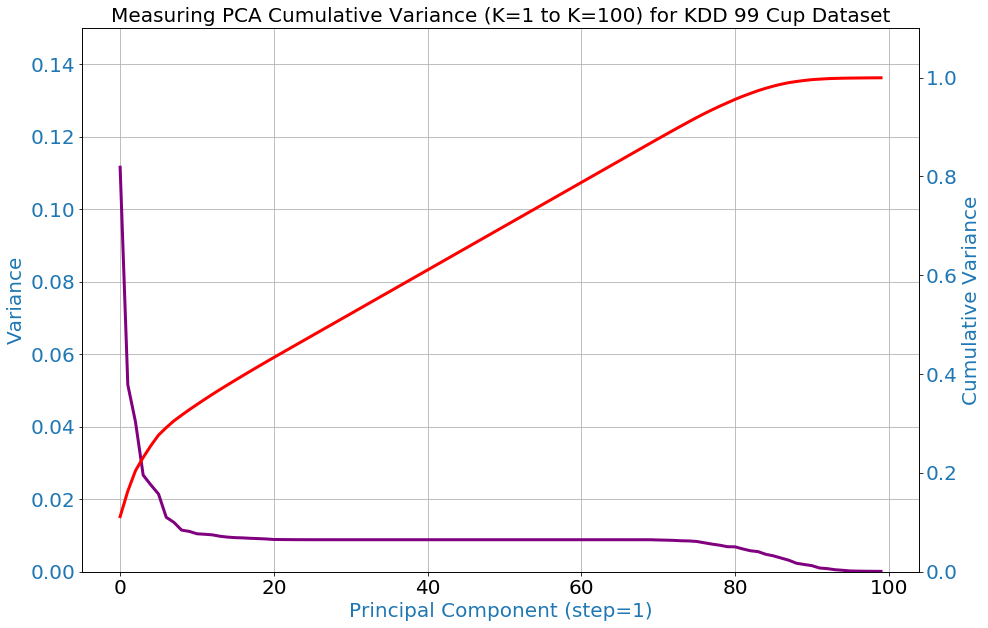

In [67]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

pca_cumsum = pca_df.cumsum()

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(pca_df, color='purple', linewidth=3.0,)

ax.set_title('Measuring PCA Cumulative Variance (K=1 to K=100) for KDD 99 Cup Dataset', size=20)
ax.set_xlabel('Principal Component (step=1)', color='tab:blue', size=20)
ax.set_ylabel('Variance', color='tab:blue', size=20)

ax.grid()
ax.set_ylim([0.0,0.15])

ax2 = ax.twinx()
ax2.set_ylim([0.0,1.1])
ax2.set_ylabel('Cumulative Variance', color='tab:blue', size=20)
ax2.plot(pca_cumsum, color='red', linewidth=3.0,)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=20)

plt.show()

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

# A label não é utilizada no vector de Features, obviamente, mas vamos encodar o label para mais à frente 
# podermos aplicar filtros de cores nos plots com o resultado do PCA

indexer = StringIndexer(inputCol="label", outputCol="label_idx")
indexed = indexer.fit(clustered).transform(clustered)

# PCA no scaledFeatureVector
pca = PCA(k=2, inputCol="scaledFeatureVector", outputCol="pcaFeatures")
model = pca.fit(indexed.select('label_idx','scaledFeatureVector'))
res = model.transform(indexed.select('label_idx', 'scaledFeatureVector'))
result = res.select("label_idx", "pcaFeatures")

In [ ]:
result = result.where(result.label_idx > 0.00)

In [ ]:
result.count()

In [83]:
%%spark -n 213231 -o result

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

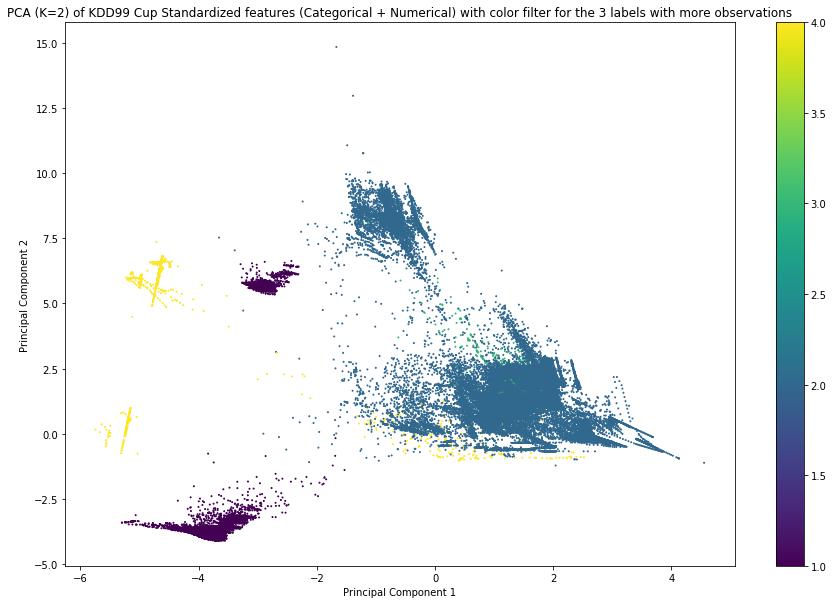

In [85]:
%%local
import numpy as np
import pandas as pd
import json

ss = result[result['label_idx']<5.00]['pcaFeatures'].values
res_list = []
for dic in ss:
    for key, value in dic.items():
        if key == "values":
            res_list.append(value)

labels = np.array(result[result['label_idx']<5.00]['label_idx'].tolist()).reshape(-1)
features = np.array(res_list).reshape(-1, 2)
cdict = {0: 'smurf', 1: 'neptune', 2: 'normal'}

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('PCA (K=2) of KDD99 Cup Standardized features (Categorical + Numerical) with color filter for the 3 labels with more observations')
ax.set_ylabel('Principal Component 2')
ax.set_xlabel('Principal Component 1')
plt.scatter(features[:, 0], features[:, 1], c=labels, s=1)
plt.colorbar();

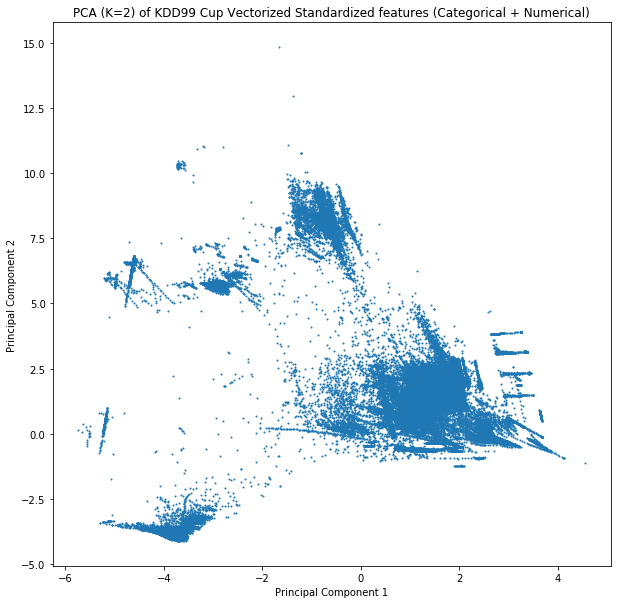

In [86]:
%%local
import numpy as np
import pandas as pd
import json

ss = result['pcaFeatures'].values
res_list = []
for dic in ss:
    for key, value in dic.items():
        if key == "values":
            res_list.append(value)

labels = np.array(result['label_idx'].tolist()).reshape(-1)
features = np.array(res_list).reshape(-1, 2)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(features[:, 0], features[:, 1],s=1)
ax.set_title('PCA (K=2) of KDD99 Cup Vectorized Standardized features (Categorical + Numerical)')
ax.set_ylabel('Principal Component 2')
ax.set_xlabel('Principal Component 1')
plt.plot();

In [40]:

import pyspark.sql.functions as F
from pyspark.sql.functions import *

global_dist_95percentile = clustered_with_sqdist.groupby('cluster').agg(
     F.expr('count(cluster)').alias('count'),
     F.expr('min(distsq)').alias('min'),
     F.expr('percentile(distsq, array(0.25))')[0].alias('%25'),
     F.expr('percentile(distsq, array(0.50))')[0].alias('%50'),
     F.expr('percentile(distsq, array(0.75))')[0].alias('%75'),
     F.expr('percentile(distsq, array(0.95))')[0].alias('%95'),
     F.expr('percentile(distsq, array(0.99))')[0].alias('%99'),
     F.expr('percentile(distsq, array(0.995))')[0].alias('%99.5'),
     F.expr('max(distsq)').alias('max')
)

anomalies_dfe = clustered_with_sqdist.where(clustered_with_sqdist.distsq >= anomaly_dist_threshold). \
    groupBy('cluster').agg(F.expr('count(cluster)').alias('anomaly_count'))
    #select('cluster','anomaly_count',lit(better_k).alias('k'), lit(anomaly_dist_threshold).alias('anomaly_threshold'))

global_dist_95percentile = global_dist_95percentile.alias('global_dist_95percentile')
anomalies_dfe = anomalies_dfe.alias('anomalies_dfe')

cluster_statistic_dataframe = global_dist_95percentile.join(anomalies_dfe, global_dist_95percentile.cluster == anomalies_dfe.cluster,how='left') \
.select('global_dist_95percentile.*', lit(anomaly_dist_threshold).alias('anomaly_threshold'), lit(better_k).alias('k'), 'anomalies_dfe.anomaly_count') \
.na.fill(0).orderBy("anomaly_count")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
%%spark -o cluster_statistic_dataframe

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

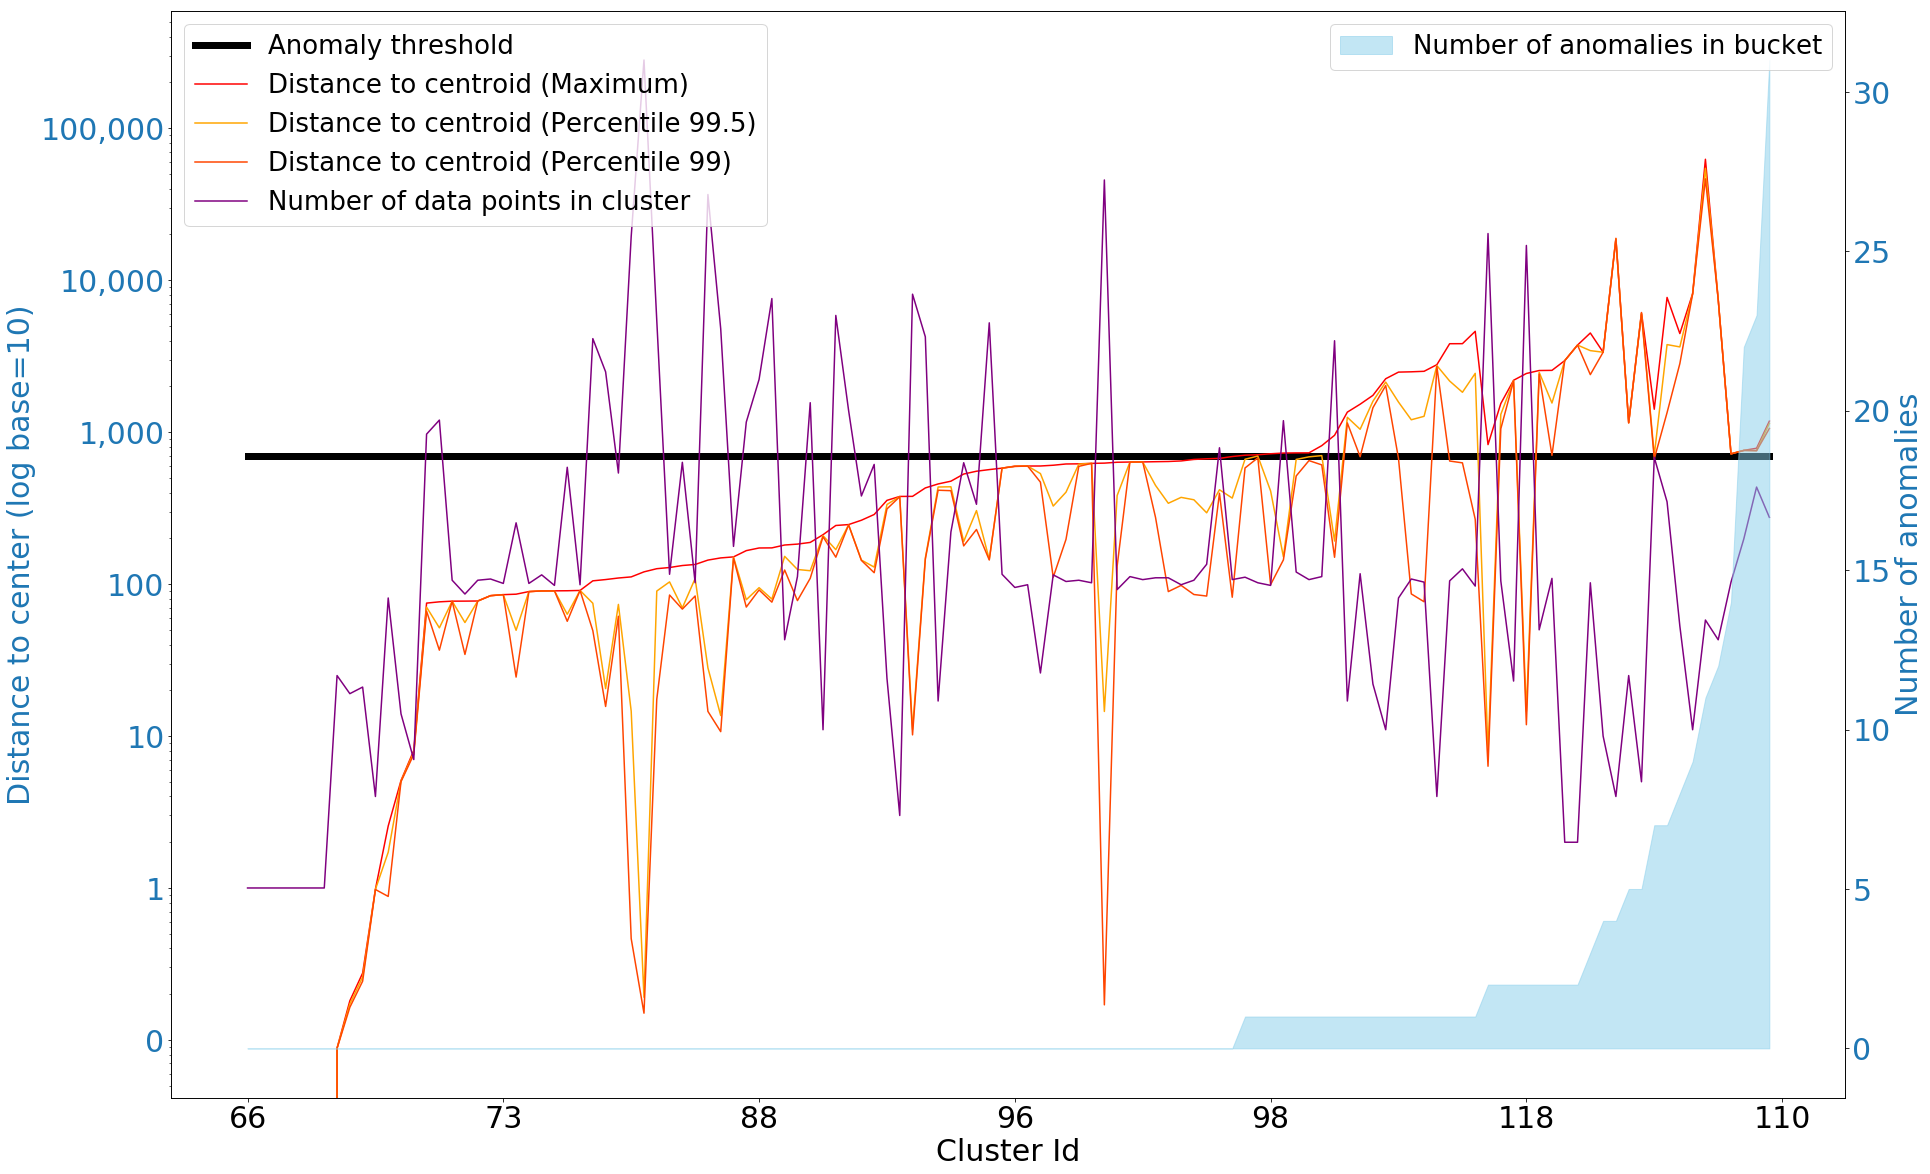

In [89]:
%%local
import numpy as np
import itertools

import matplotlib.pyplot as plt

cluster = cluster_statistic_dataframe['cluster'].values.tolist()
distance_max = cluster_statistic_dataframe['max'].values.tolist()
distance_min = cluster_statistic_dataframe['min'].values.tolist()
distance_count = cluster_statistic_dataframe['count'].values.tolist()
distance_25 = cluster_statistic_dataframe['%25'].values.tolist()
distance_50 = cluster_statistic_dataframe['%50'].values.tolist()
distance_75 = cluster_statistic_dataframe['%75'].values.tolist()
distance_95 = cluster_statistic_dataframe['%95'].values.tolist()
distance_99 = cluster_statistic_dataframe['%99'].values.tolist()
distance_995 = cluster_statistic_dataframe['%99.5'].values.tolist()
anomaly_count = cluster_statistic_dataframe['anomaly_count'].values.tolist()
data_point_count = cluster_statistic_dataframe['count'].values.tolist()
kmeans_k = cluster_statistic_dataframe['k'].values.tolist()
anomaly_threshold = cluster_statistic_dataframe['anomaly_threshold'].values.tolist()
cluster_number = len(cluster)

anomaly_count, anomaly_threshold, distance_max, distance_95, distance_99, distance_995, data_point_count, cluster = zip(*sorted(zip(anomaly_count, anomaly_threshold, distance_max, distance_95, distance_99, distance_995, data_point_count, cluster)))

fig, ax1 = plt.subplots(figsize=(30,20))

# Axis 1
ax1.set_xlabel('Cluster Id', size=30)
ax1.set_ylabel('Distance to center (log base=10)', color='tab:blue', size=30)
ax1.set_yscale('log')
ax1.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.plot(anomaly_threshold, color='black', linewidth=7.0, label='Anomaly threshold')
ax1.plot(distance_max, color='red', label='Distance to centroid (Maximum)')
ax1.plot(distance_995, color='orange', label='Distance to centroid (Percentile 99.5)')
ax1.plot(distance_99, color='orangered', label='Distance to centroid (Percentile 99)')
ax1.plot(data_point_count, color='purple', label='Number of data points in cluster')

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=30)

ax1.set_xticklabels(cluster)
ax1.legend(loc=2, prop={'size': 26})

# Axis 2
ax2 = ax1.twinx()
ax2.set_ylabel('Number of anomalies', color='tab:blue', size=30)
ax2.fill_between(np.arange(cluster_number), anomaly_count, color="skyblue",
                 alpha=0.5, label='Number of anomalies in bucket')
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=30)
ax2.legend(loc=1, prop={'size': 26})

plt.show()

In [39]:
sum_squared_error_dict_df = sc.parallelize([(k,)+(v,) for k,v in sum_squared_error_dict.items()]).toDF(['k','sum_squared_error'])
weighted_cluster_entropy_dict_df = sc.parallelize([(k,)+(v,) for k,v in weighted_cluster_entropy_dict.items()]).toDF(['k2','weighed_cluster_entropy'])
silhouette_score_dict_df = sc.parallelize([(k,)+(v,) for k,v in silhouette_score_dict.items()]).toDF(['k3','silhouette_score'])

clustering_metrics_tmp = sum_squared_error_dict_df.join(weighted_cluster_entropy_dict_df, sum_squared_error_dict_df.k == weighted_cluster_entropy_dict_df.k2)
clustering_metrics = clustering_metrics_tmp.join(silhouette_score_dict_df, clustering_metrics_tmp.k == silhouette_score_dict_df.k3).drop('k2', 'k3').orderBy('k')


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [91]:
%%spark -o clustering_metrics

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<Figure size 432x288 with 0 Axes>

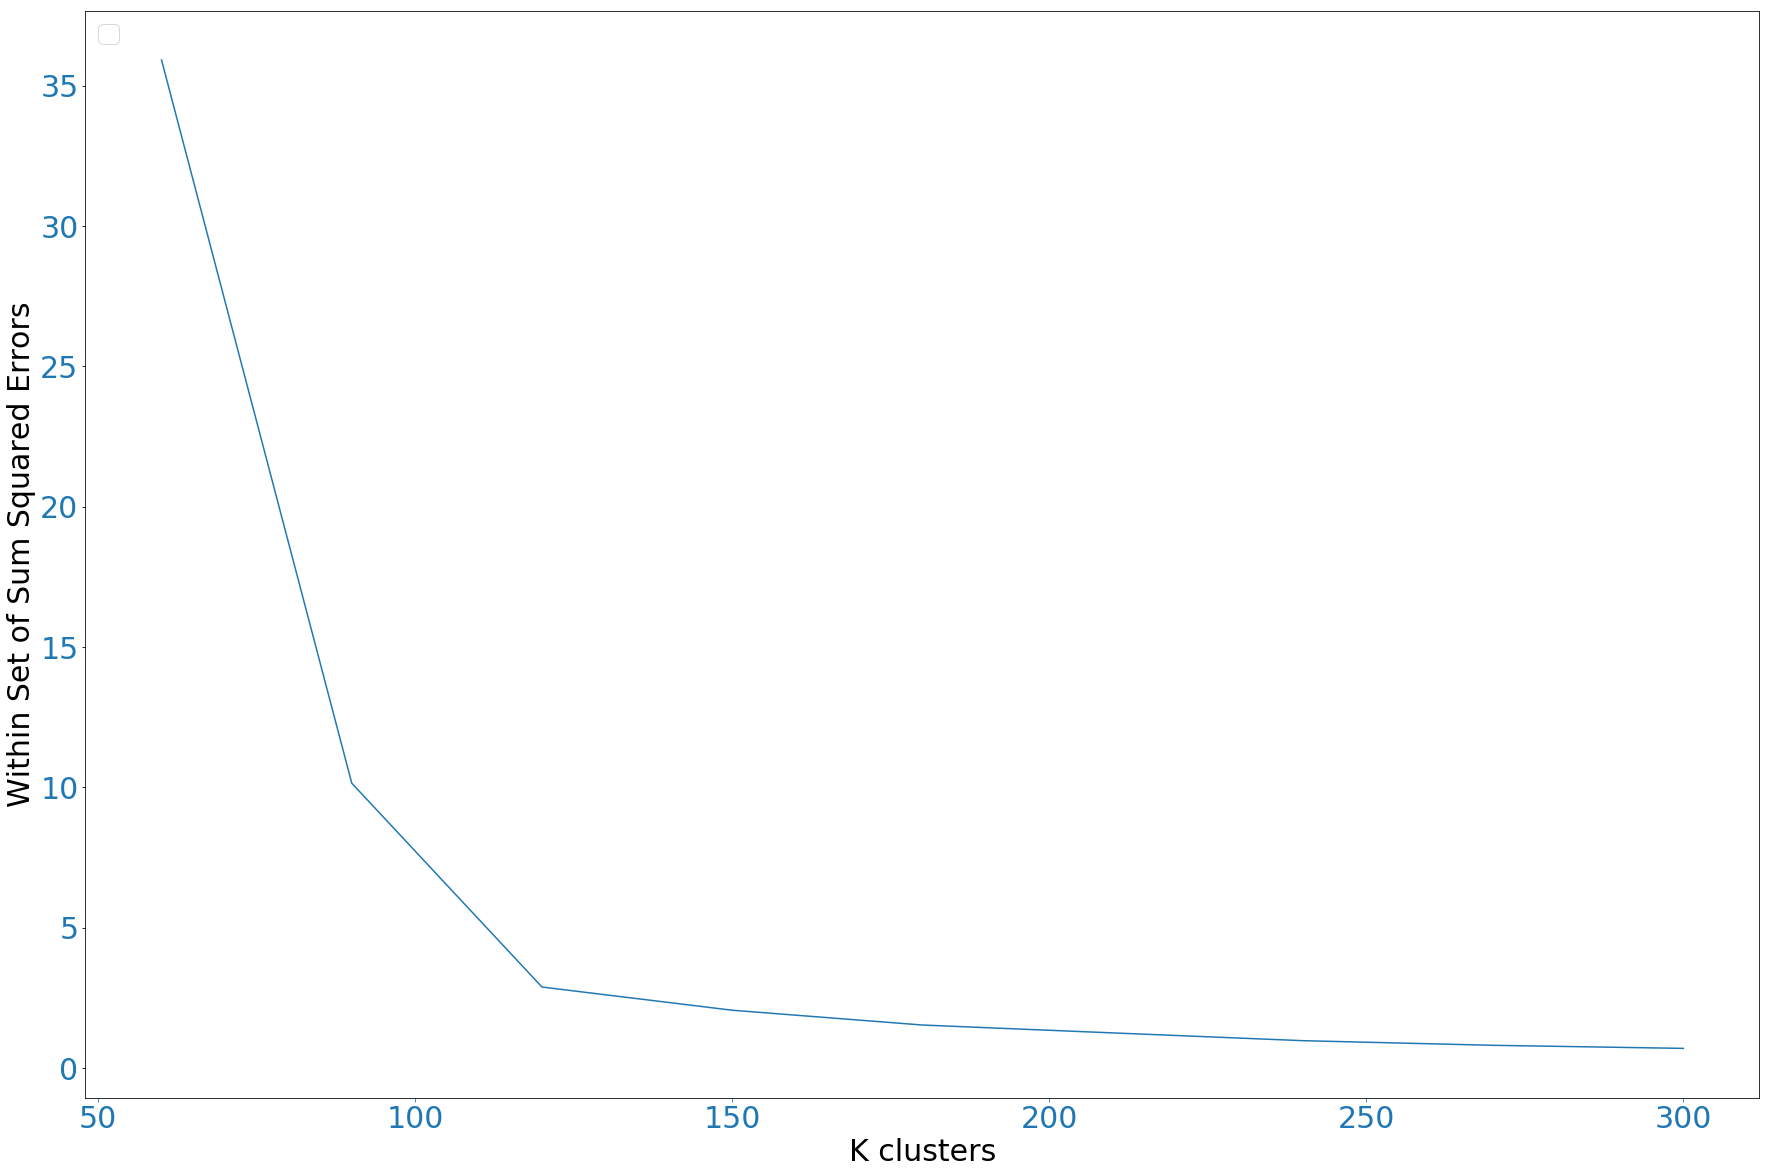

In [92]:
%%local
import matplotlib.pyplot as plt
import numpy as np

k = clustering_metrics['k'].values.tolist()
sum_squared_error = clustering_metrics['sum_squared_error'].values.tolist()

fig = plt.figure()
plt.subplots(figsize=(30,20))

ax = plt.axes()
ax.set_xlabel('K clusters', size=30)
ax.legend(loc=2, prop={'size': 26})
ax.tick_params(axis='x', labelcolor='tab:blue', color='tab:blue', labelsize=30)
ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=30)
ax.set_ylabel('Within Set of Sum Squared Errors', size=30)

ax.plot(k, sum_squared_error);

<Figure size 432x288 with 0 Axes>

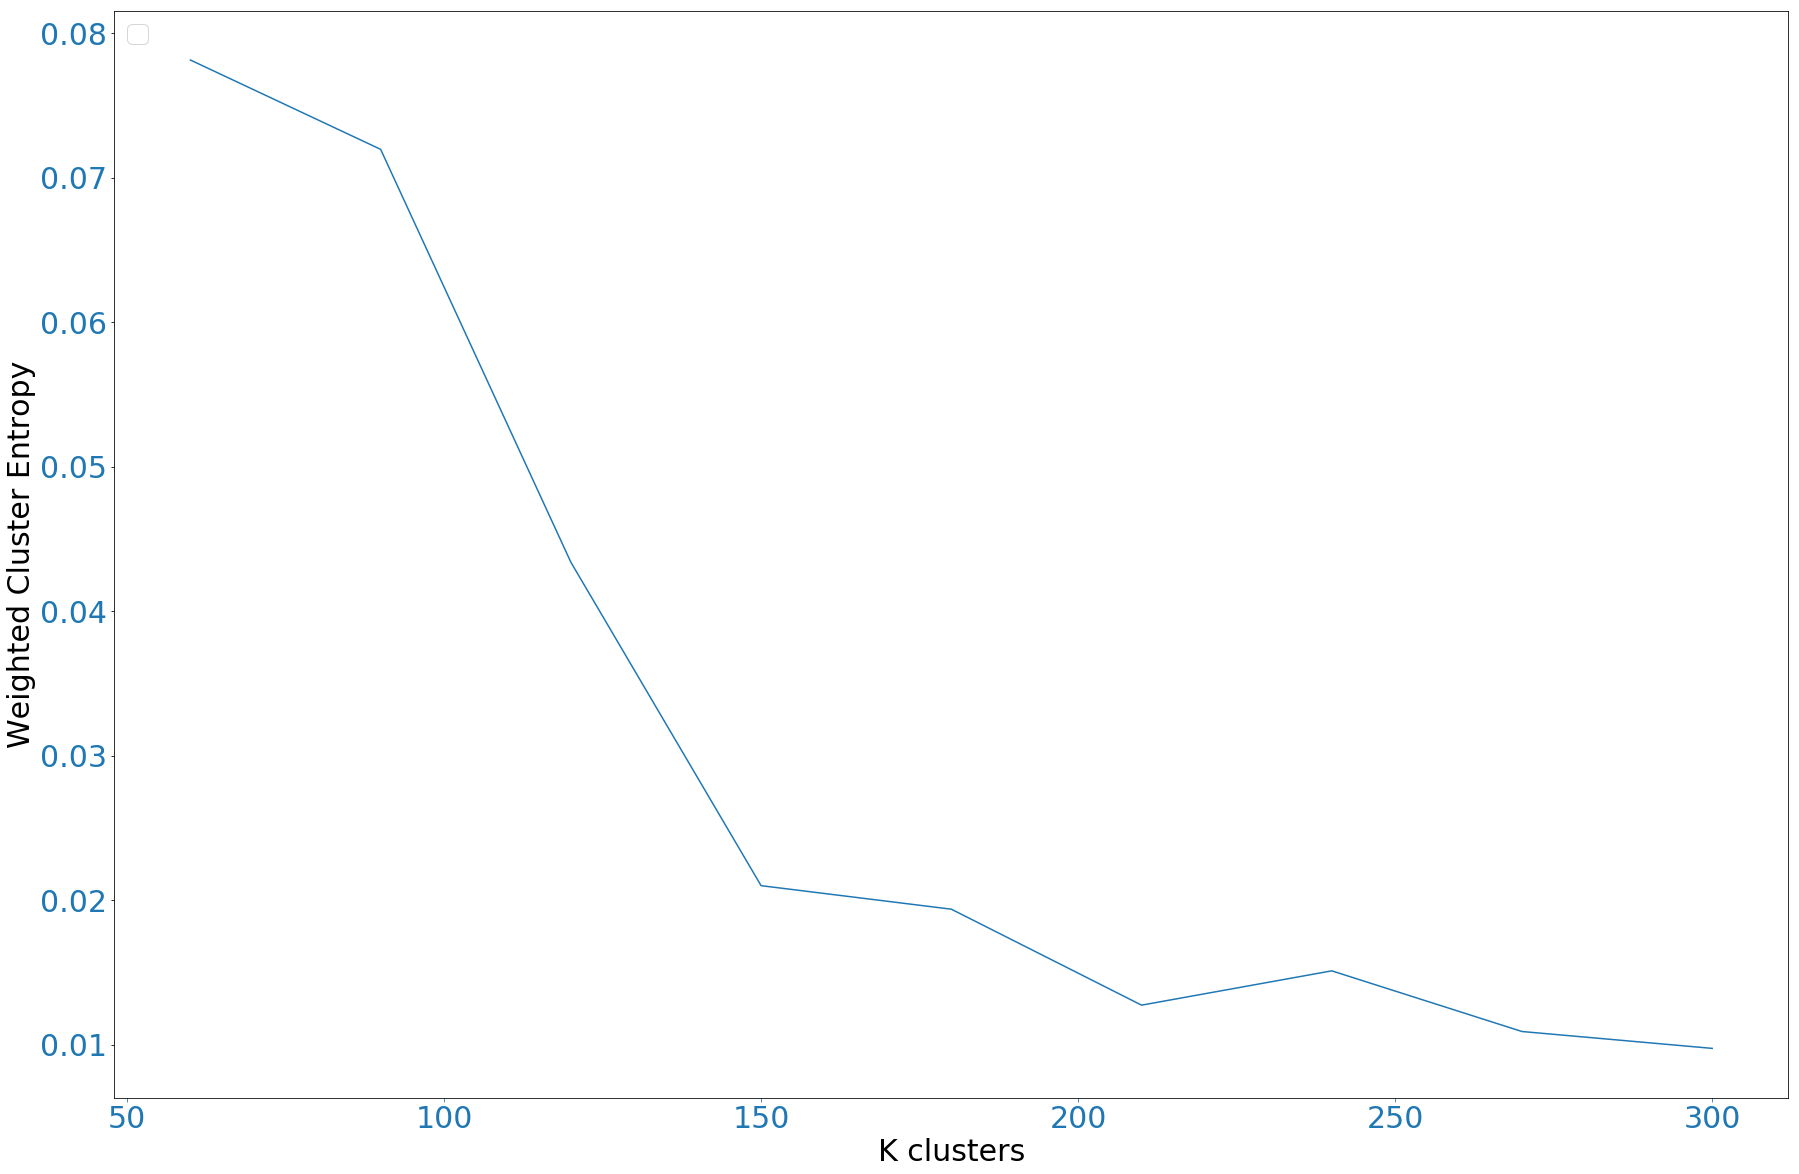

In [93]:
%%local
import matplotlib.pyplot as plt
import numpy as np

k = clustering_metrics['k'].values.tolist()
weighed_cluster_entropy = clustering_metrics['weighed_cluster_entropy'].values.tolist()

fig = plt.figure()
plt.subplots(figsize=(30,20))

ax = plt.axes()
ax.set_xlabel('K clusters', size=30)
ax.legend(loc=2, prop={'size': 26})
ax.tick_params(axis='x', labelcolor='tab:blue', color='tab:blue', labelsize=30)
ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=30)
ax.set_ylabel('Weighted Cluster Entropy', size=30)

ax.plot(k, weighed_cluster_entropy);


<Figure size 432x288 with 0 Axes>

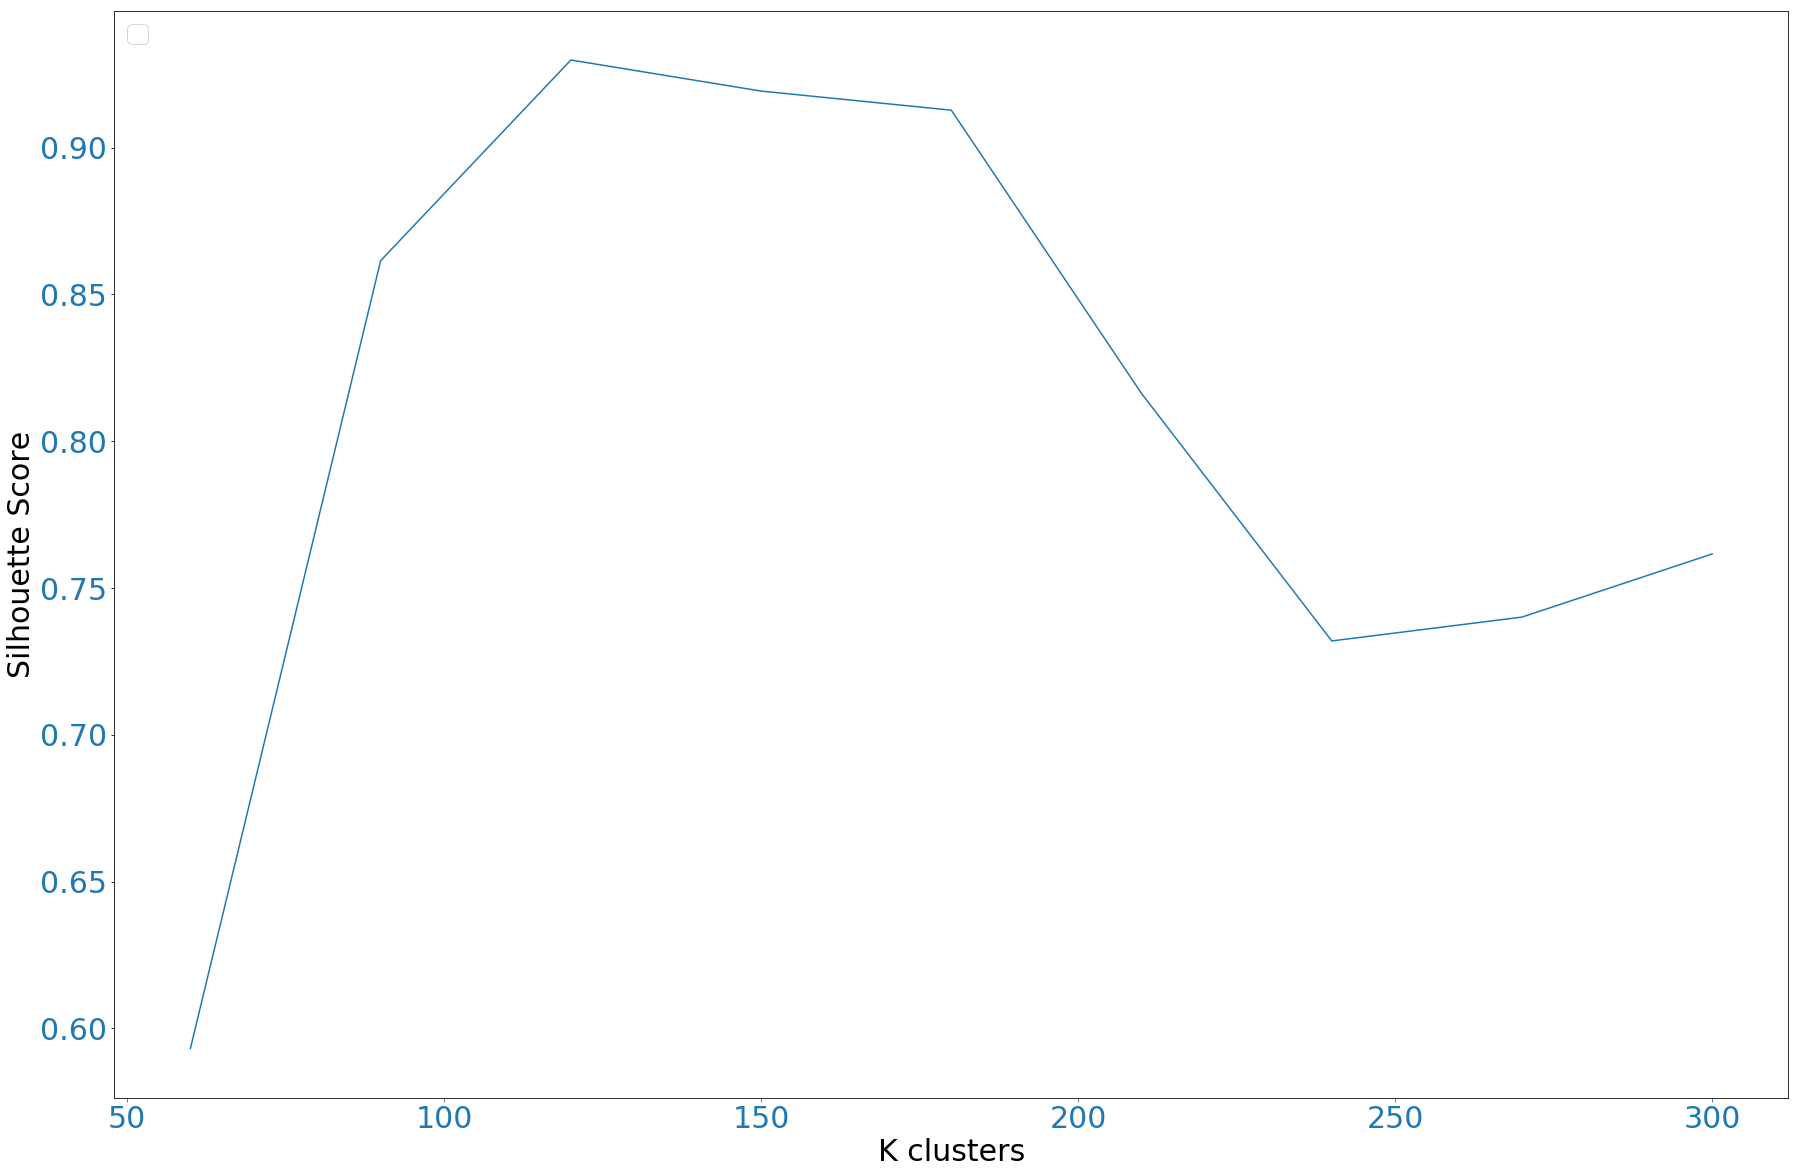

In [94]:
%%local
import matplotlib.pyplot as plt
import numpy as np

k = clustering_metrics['k'].values.tolist()
silhouette_score = clustering_metrics['silhouette_score'].values.tolist()

fig = plt.figure()
plt.subplots(figsize=(30,20))

ax = plt.axes()
ax.set_xlabel('K clusters', size=30)
ax.legend(loc=2, prop={'size': 26})
ax.tick_params(axis='x', labelcolor='tab:blue', color='tab:blue', labelsize=30)
ax.tick_params(axis='y', labelcolor='tab:blue', labelsize=30)
ax.set_ylabel('Silhouette Score', size=30)

ax.plot(k, silhouette_score);

In [43]:
#sc.install_pypi_package("matplotlib", "https://pypi.org/simple") #Install matplotlib from given PyPI repository

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer

# A label não é utilizada no vector de Features, obviamente, mas vamos encodar o label para mais à frente 
# podermos aplicar filtros de cores nos plots com o resultado do PCA

indexer = StringIndexer(inputCol="label", outputCol="label_idx")
indexed = indexer.fit(clustered).transform(clustered)

# PCA no scaledFeatureVector
pca = PCA(k=3, inputCol="scaledFeatureVector", outputCol="pcaFeatures")
model = pca.fit(indexed.select('label_idx','scaledFeatureVector'))
res = model.transform(indexed.select('label_idx', 'scaledFeatureVector'))
result = res.select("label_idx", "pcaFeatures")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
result = result.where(result.label_idx > 2.00)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
result.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

8752

In [37]:
%%spark -n 8752 -o result

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

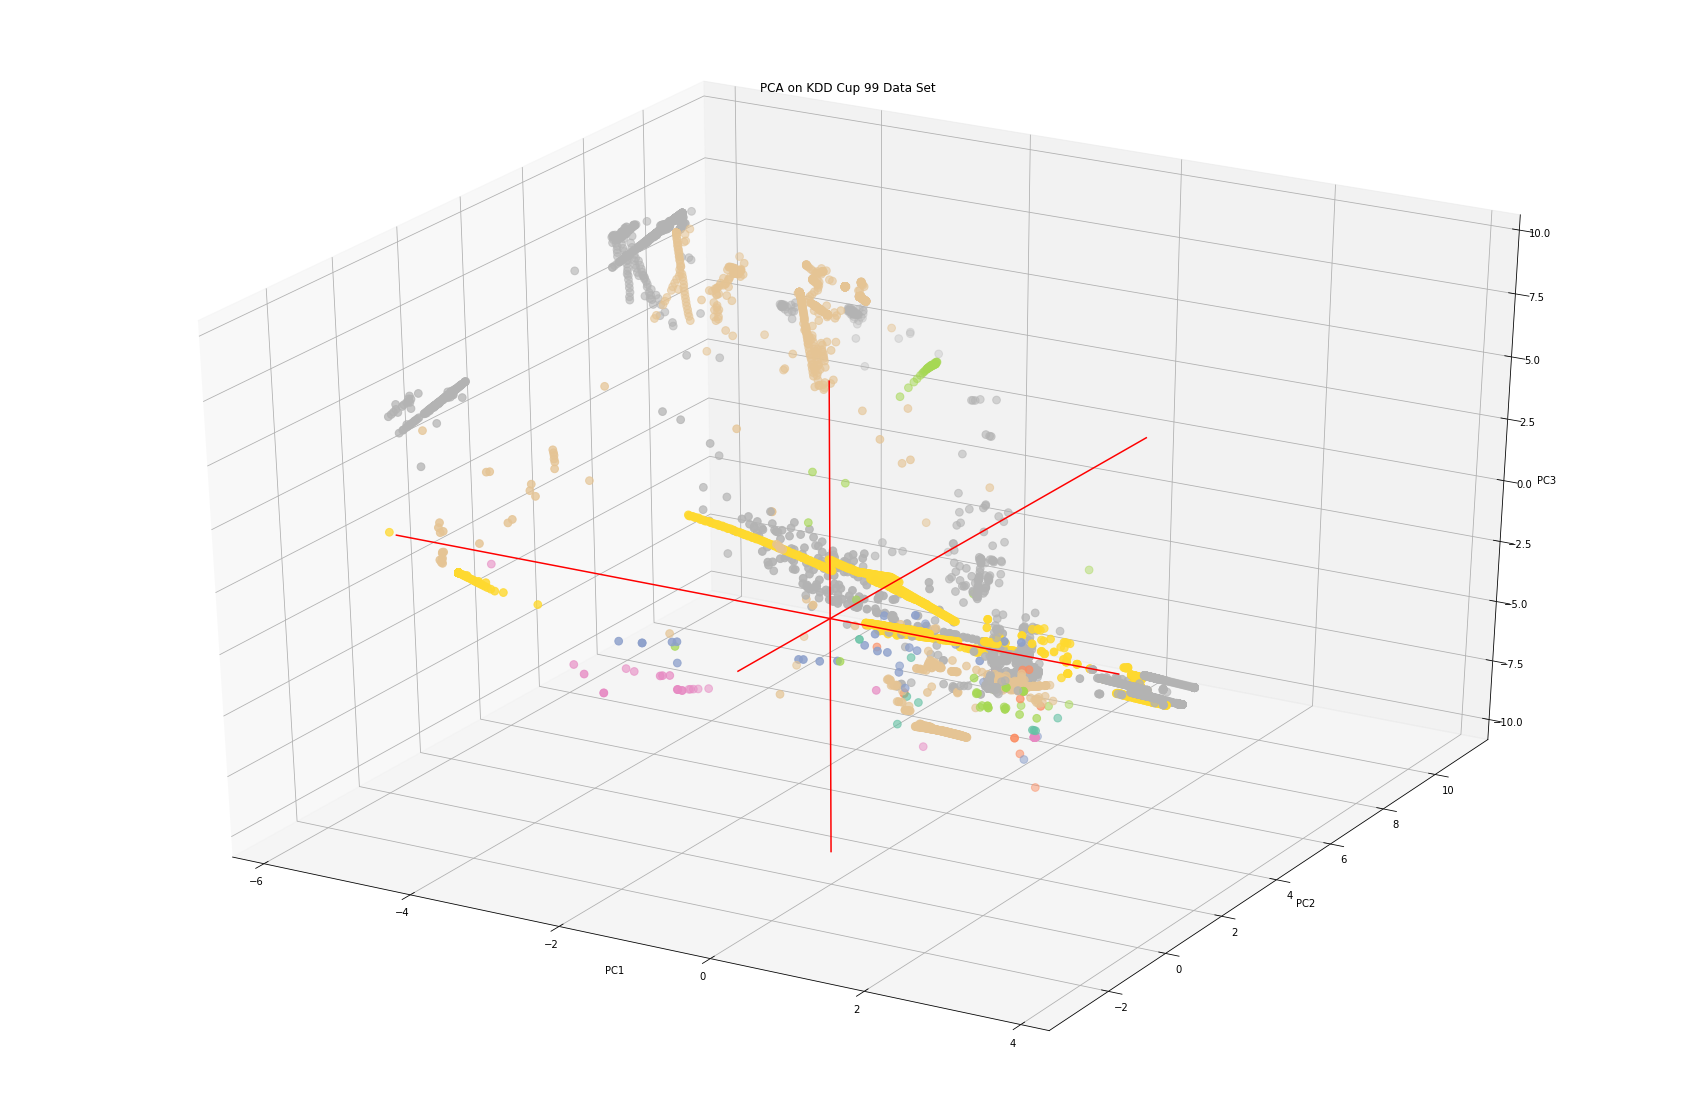

In [38]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

ss = result['pcaFeatures'].values
res_list = []
for dic in ss:
    for key, value in dic.items():
        if key == "values":
            res_list.append(value)

labels = np.array(result['label_idx'].tolist()).reshape(-1)
features = np.array(res_list).reshape(-1, 3)

# Plot initialisation
fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap="Set2_r", s=60)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(features[:, 0]), max(features[:, 0])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(features[:, 1]), max(features[:, 1])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(features[:, 2]), max(features[:, 2])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on KDD Cup 99 Data Set")
plt.show()

In [44]:
#clustered_with_sqdist.groupby('cluster').count().orderBy('cluster', ascending=False).show()
#from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
import pyspark.sql.functions as F
from pyspark.sql.functions import *

dist_stdev_analysis = clustered_with_sqdist.groupby('cluster').agg(
     F.expr('count(cluster)').alias('count'),
     F.expr('min(distsq)').alias('min'),
     F.expr('mean(distsq)').alias('mean'),
     F.expr('percentile(distsq, array(0.25))')[0].alias('%25'),
     F.expr('percentile(distsq, array(0.50))')[0].alias('%50'),
     F.expr('percentile(distsq, array(0.75))')[0].alias('%75'),
     F.expr('percentile(distsq, array(0.95))')[0].alias('%95'),
     F.expr('percentile(distsq, array(0.99))')[0].alias('%99'),
     F.expr('percentile(distsq, array(0.995))')[0].alias('%99.5'),
     F.expr('max(distsq)').alias('max'),
     F.expr('stddev(distsq)').alias('stdev_dist')
).select('cluster','count','stdev_dist').na.drop()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [112]:
%%spark -o dist_stdev_analysis

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

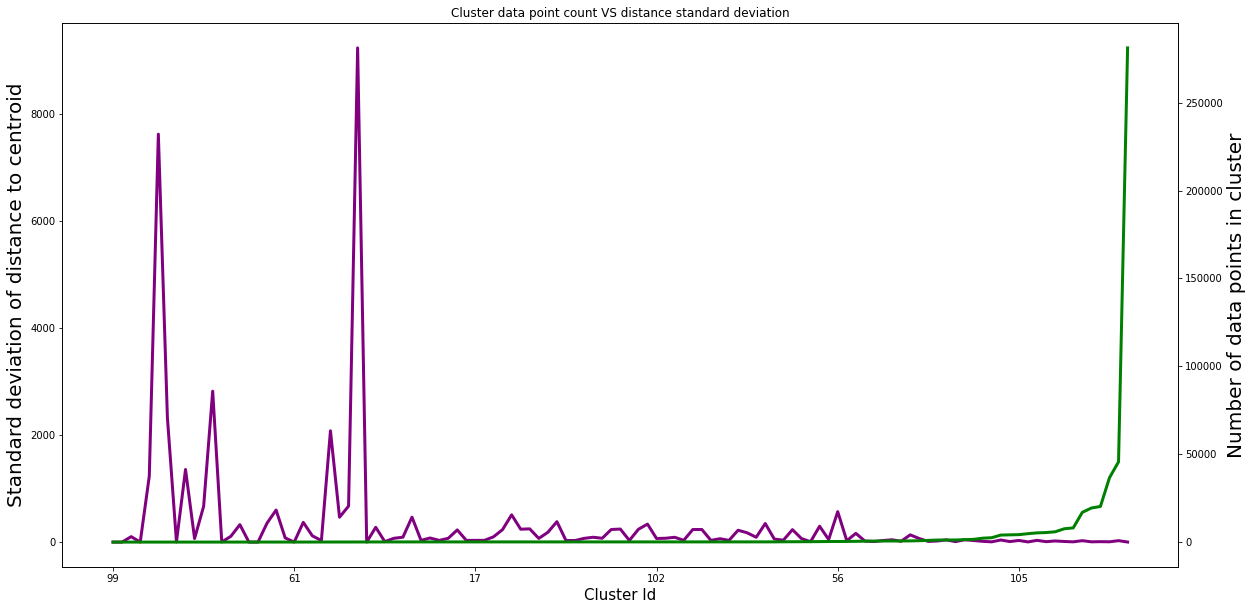

In [113]:
%matplotlib inline

import random
import numpy
from matplotlib import pyplot

counts = dist_stdev_analysis['count'].values.tolist()
stdev = dist_stdev_analysis['stdev_dist'].values.tolist()
cluster = dist_stdev_analysis['cluster'].values.tolist()

counts, stdev, cluster = zip(*sorted(zip(counts, stdev, cluster)))

fig, ax1 = pyplot.subplots(figsize=(20,10))

ax1.plot(stdev, color='purple', linewidth=3.0,)

ax2 = ax1.twinx()

ax2.plot(counts, color='green', linewidth=3.0,)
ax1.set_xticklabels(cluster)
ax1.set_xlabel('Cluster Id', size=15)
ax1.set_ylabel('Standard deviation of distance to centroid', size=20)
ax2.set_ylabel('Number of data points in cluster', size=20)
ax1.set_title("Cluster data point count VS distance standard deviation")

pyplot.show()

In [ ]:
from pyspark.ml.clustering import GaussianMixture

gaussianMixture = GaussianMixture(maxIter=10). \
setK(better_k). \
setFeaturesCol("pcaFeatures"). \
setPredictionCol("gm_cluster"). \
setProbabilityCol("gm_cluster_p"). \
setSeed(int(np.random.randint(100, size=1)))

gm_model = gaussianMixture.fit(res).transform(res)
gm_model.gaussiansDF.show(truncate=False)